In [ ]:
# !nvidia-smi

In [2]:
!which python

/Users/ildar/projects/.venv/bin/python


In [3]:
# !pip install numpy
# !pip install tqdm
# !pip install scikit-learn
# !pip install tensorflow-macos
# !pip install keras_nlp
# !pip install matplotlib
# !pip install gensim==3.8.3 -U
# !pip install ipywidgets

In [4]:
import numpy as np
from tqdm.notebook import tqdm

In [5]:
import os
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

files = ['NLU-Evaluation-Data/AnnotatedData/NLU-Data-Home-Domain-Annotated-All.csv']
labels = []
sentences = []

for filename in files: 
    with open(filename, encoding='utf-8') as f:
        for line in f.readlines():
            line = line.split(';')
            if line[8]:
                sentences.append(line[8])
                labels.append(line[2] + '_' + line[3])

le = LabelEncoder()
ohe = OneHotEncoder()
ohe.fit(le.fit_transform(labels).reshape(-1, 1))

labels = np.array(labels)
sentences = np.array(sentences)
len(labels), len(sentences)

(20819, 20819)

# оставляем только 1 пример

In [6]:
labels = labels[367:368]
sentences = sentences[367:368]
labels, sentences

(array(['news_query'], dtype='<U24'),
 array(["what's sensational in time of india"], dtype='<U365'))

In [7]:
max_len = -1
lengths = []
for message in sentences:
    max_len = len(message.split()) if len(message.split()) > max_len else max_len
    lengths.append(len(message.split()))
max_len

6

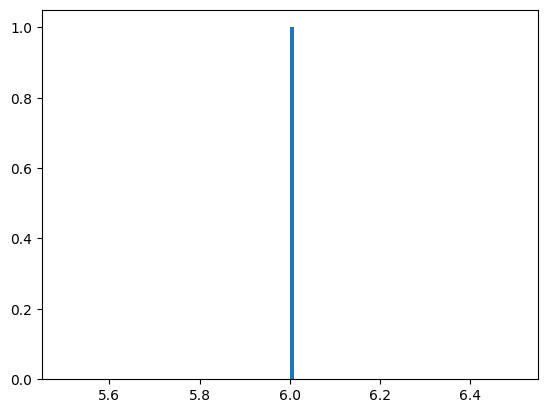

In [8]:
import matplotlib.pyplot as plt
plt.hist(lengths, bins=100)
plt.show()

In [9]:
TARGET_LEN = 52
EMBEDDING_SIZE = 200

# !!!ЭМБЕДИНГИ НЕ КАЧЕСТВЕННЫЕ, не сдавайся

In [10]:
import pickle
with open('word2vec_100.pkl', 'rb') as rf:
    W2V_100 = pickle.load(rf)
with open('fasttext_100.pkl', 'rb') as rf:
    FT_100 = pickle.load(rf)

In [11]:
W2V_100.wv.most_similar(positive='please'), FT_100.wv.most_similar('me')

([('google', 0.5979539155960083),
  ('siri', 0.5428193211555481),
  ('wanna', 0.5294137001037598),
  ('hey', 0.5242522954940796),
  ('gotta', 0.5072860717773438),
  ('yourself', 0.49988099932670593),
  ('dialog', 0.48816388845443726),
  ('reschedule', 0.4799187183380127),
  ('your', 0.4734569489955902),
  ("let's", 0.4709016978740692)],
 [('us', 0.7899342775344849),
  ('him', 0.7358138561248779),
  ('meowk', 0.7257457375526428),
  ('mekk3', 0.7218108177185059),
  ('jme', 0.7211407423019409),
  ('rème', 0.7180854678153992),
  ('dáme', 0.716890275478363),
  ('dôme', 0.7083154916763306),
  ('jérôme', 0.707120418548584),
  ('gme', 0.7071195244789124)])

In [12]:
def pad_sequences(sequence, target_len: int=20, embedding_size: int=300) -> np.array:
    sequence = np.array(sequence)
    if sequence.size == 0:
        # empty array
        current_length = 0
        return np.zeros((target_len, embedding_size))
    elif len(sequence.shape) == 1:
        sequence = np.array([sequence])
        current_length = 1
    else:
        current_length = sequence.shape[0]
        
    if current_length >= target_len:
        return sequence[-target_len:]
    
    # padding = np.random.uniform(size=(target_len - current_length, embedding_size))
    padding = np.zeros((target_len - current_length, embedding_size))
    return np.concatenate((padding, sequence), axis=0)

In [13]:
from tqdm.notebook import tqdm
def vectorize_sentence(sentence):
    vec = []
    for token in sentence.split():
        tkn_vec = np.concatenate((W2V_100.wv[token], FT_100.wv[token]), axis=0)
        vec.append(tkn_vec)
    return pad_sequences(vec, target_len=TARGET_LEN, embedding_size=EMBEDDING_SIZE)

In [14]:
RANDOM_DIM = 100


class DataGenerator():
    def __init__(self, labels, sentences, batches_per_epoch, batch_size):
        self.train_sentences = sentences
        self.train_labels = labels
        self.batches_per_epoch = batches_per_epoch
        self.batch_size = batch_size
    
    @staticmethod
    def rand_norm(npoints=1, ndim=RANDOM_DIM):
        rand_vec = np.random.normal(0, 1, size=[npoints, ndim])
        return rand_vec

    def __len__(self):
        return self.batches_per_epoch

    def batch(self):
        rand_sentences_indexes = np.random.randint(0, self.train_sentences.shape[0], size=self.batch_size)
        sent_batch = np.array([vectorize_sentence(sent) for sent in self.train_sentences[rand_sentences_indexes]])
        labels_batch = ohe.transform(le.transform(self.train_labels[rand_sentences_indexes]).reshape(-1, 1)).todense()
        return sent_batch, labels_batch

    def __iter__(self):
        for b in tqdm(range(self.batches_per_epoch), leave=False):
            yield self.batch()

    def rand_batch(self):
        rand_vec = self.rand_norm(self.batch_size)
        # for training generator with label
        rand_labels = np.random.randint(0, len(le.classes_), size=[self.batch_size])
        rand_labels = ohe.transform(rand_labels.reshape(-1, 1)).todense()
        return (rand_vec, rand_labels)

    
np.random.seed(42)
sent_indexes = np.random.randint(0, len(sentences), size=1)
MESSAGES_FROM_DATASET = [sentences[sent_indexes], labels[sent_indexes]]
FIXED_NOISE = [DataGenerator.rand_norm(1), ohe.transform(le.transform(labels[sent_indexes]).reshape(-1, 1)).todense()]
MESSAGES_FROM_DATASET

[array(["what's sensational in time of india"], dtype='<U365'),
 array(['news_query'], dtype='<U24')]

# GENERATOR

Metal device set to: Apple M1 Pro
(3, 52, 200)


2022-11-27 14:27:30.181031: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-27 14:27:30.181368: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


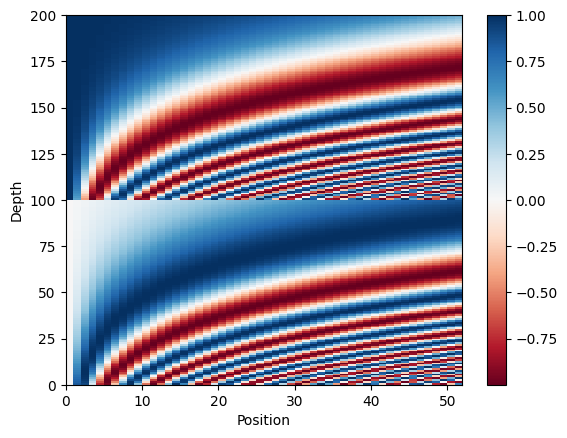

In [15]:
import tensorflow as tf

def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(50, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def give_pe(batch_size, position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    # angle_rads = angle_rads[np.newaxis, ...]

    return tf.constant([angle_rads for _ in range(batch_size)])

b, n, d = 3, 52, 200
pos_encoding = give_pe(b, n, d)

print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

In [16]:
from tensorflow import keras
from tensorflow.keras import backend as K
import numpy as np

def make_generator(complexity=180):
    alpha = 0.2
    complexity = int(complexity)
    
    random_vector = keras.layers.Input(shape=[RANDOM_DIM])
    labels = keras.layers.Input(shape=[len(le.classes_)])
    
    X = keras.layers.Concatenate()([random_vector, labels])
    
    # layer 1
    X = keras.layers.Dense(
        TARGET_LEN//2//2*complexity,
        kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02),
    )(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.LeakyReLU(alpha)(X)
    X = keras.layers.Reshape((TARGET_LEN//2//2, complexity))(X)
    
    #layer 2 (None, 13, complexity)
    X = keras.layers.Conv1DTranspose(
        filters=complexity//2,
        kernel_size=3,
        padding='same',
        strides=1,
    )(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.LeakyReLU(alpha)(X)
    
    #layer 3 (None, 13, complexity/2)
    X = keras.layers.Conv1DTranspose(
        filters=complexity,
        kernel_size=3,
        padding='same',
        strides=2,
    )(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.LeakyReLU(alpha)(X)
    
    #layer 4 (None, 26, complexity/2)
    pe = K.tile(give_pe(1, 26, 200), (K.shape(X)[0], 1, 1))
    X = keras.layers.Concatenate(axis=-1)([X, pe])
    X = keras.layers.Conv1DTranspose(
        filters=complexity,
        kernel_size=3,
        padding='same',
        strides=2,
    )(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.LeakyReLU(alpha)(X)
    
    
    #layer 5 (None, 52, complexity)
    pe = K.tile(give_pe(1, 52, 200), (K.shape(X)[0], 1, 1))
    X = keras.layers.Concatenate(axis=-1)([X, pe])
    X = keras.layers.Conv1DTranspose(
        filters=complexity,
        kernel_size=3,
        padding='same',
        strides=1,
    )(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.LeakyReLU(alpha)(X)
    
    #layer 6 (None, 52, complexity)
    pe = K.tile(give_pe(1, 52, 200), (K.shape(X)[0], 1, 1))
    X = keras.layers.Concatenate(axis=-1)([X, pe])
    X = keras.layers.Conv1DTranspose(
        filters=complexity,
        kernel_size=3,
        padding='same',
        strides=1,
    )(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.LeakyReLU(alpha)(X)
    
    
    #layer 6 (None, 52, complexity)
    pe = K.tile(give_pe(1, 52, 200), (K.shape(X)[0], 1, 1))
    X = keras.layers.Concatenate(axis=-1)([X, pe])
    X = keras.layers.Conv1DTranspose(
        filters=complexity,
        kernel_size=3,
        padding='same',
        strides=1,
    )(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.LeakyReLU(alpha)(X)
    
    
    #layer 6 (None, 52, complexity)
    pe = K.tile(give_pe(1, 52, 200), (K.shape(X)[0], 1, 1))
    X = keras.layers.Concatenate(axis=-1)([X, pe])
    X = keras.layers.Conv1DTranspose(
        filters=complexity,
        kernel_size=3,
        padding='same',
        strides=1,
    )(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.LeakyReLU(alpha)(X)
    
    
    
    #layer 7 (None, 52, complexity)
    X = keras.layers.Conv1DTranspose(
        filters=complexity,
        kernel_size=3,
        padding='same',
        strides=1,
    )(X)
    X = keras.layers.BatchNormalization()(X)
    X = keras.layers.LeakyReLU(alpha)(X)
    
    X = keras.layers.Dense(EMBEDDING_SIZE)(X)
    
    model = keras.models.Model(inputs=[random_vector, labels], outputs=X)
    model.compile(
        loss='binary_crossentropy',
        metrics=['acc'],
        optimizer='sgd'
    )
    model.summary()
    return model
generator = make_generator()
generated_from_noise = generator(FIXED_NOISE)
generated_from_noise.shape

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 61)]         0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 161)          0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 2340)         379080      ['concatenate[0][0]']        

TensorShape([1, 52, 200])

In [17]:
from scipy.spatial.distance import cosine


def distance_to_that_message(generated_vec):
    that_message_vec = vectorize_sentence(MESSAGES_FROM_DATASET[0][0])
    return np.mean([cosine(a, b)  for a, b in zip(generated_vec, that_message_vec)])


def message_recovery_with_metric(vector: np.ndarray):
    assert len(vector.shape) == 2
    tokens = []
    metric = []
    vector = vector.numpy()
    for token_vec in vector:
        w2v = token_vec[:100]
        if np.linalg.norm(w2v) < 0.1:
            token = ''
        else:
            token = W2V_100.wv.most_similar([w2v])[0][0]
        tokens.append(token)
        
        metric.append(cosine(token_vec[100:], FT_100.wv[token]))
    return ' '.join(tokens[-40:]).strip(), np.mean(metric), distance_to_that_message(vector)



for example in generated_from_noise:
    print(message_recovery_with_metric(example))

('actuarial actuarial actuarial actuarial brides brides lymphocyte lymphocyte lymphocyte counting amino 14 amino amino 14 14 pd pd 28 renters 339 339 heterodimer molecule blau blau eukaryote eukaryote insertions brides brides brides gametes workshared gametes compartment compartment gusto workshared fpa', 1.025869515307092, 0.11450564128997917)


/Users/ildar/projects/.venv/lib/python3.9/site-packages/scipy/spatial/distance.py:620: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


# DISCRIMINATOR

In [18]:
def optimizer():
    return tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)

In [19]:
def make_discriminator(complexity=480):
    complexity = int(complexity)
    alpha = 0.2
    drop_rate = 0.2
    inp = keras.layers.Input(shape=(TARGET_LEN, EMBEDDING_SIZE))
    X = inp
    
    #layer 1
    X = keras.layers.Conv1D(
        filters=complexity//2,
        kernel_size=3,
        padding='same',
        strides=1,
    )(X)
    X = keras.layers.LeakyReLU(alpha)(X)
    X = keras.layers.Dropout(drop_rate)(X)
    
    #layer 2
    X = keras.layers.Conv1D(
        filters=complexity//3,
        kernel_size=3,
        padding='same',
        strides=2,
    )(X)
    X = keras.layers.LeakyReLU(alpha)(X)
    X = keras.layers.Dropout(drop_rate)(X)
    
    
    #layer 2
    X = keras.layers.Conv1D(
        filters=complexity//3,
        kernel_size=3,
        padding='same',
        strides=1,
    )(X)
    X = keras.layers.LeakyReLU(alpha)(X)
    X = keras.layers.Dropout(drop_rate)(X)
    
    #layer 2
    X = keras.layers.Conv1D(
        filters=complexity//3,
        kernel_size=3,
        padding='same',
        strides=1,
    )(X)
    X = keras.layers.LeakyReLU(alpha)(X)
    X = keras.layers.Dropout(drop_rate)(X)
    
    
    #layer 3
    X = keras.layers.Conv1D(
        filters=complexity//4,
        kernel_size=3,
        padding='same',
        strides=2,
    )(X)
    X = keras.layers.LeakyReLU(alpha)(X)
    X = keras.layers.Dropout(drop_rate)(X)
    
    #layer 4
    X = keras.layers.Flatten()(X)
    X = keras.layers.Dense(complexity)(X)
    X = keras.layers.LeakyReLU(alpha)(X)
    X = keras.layers.Dropout(drop_rate)(X)
    
    #layer 5
    X = keras.layers.Flatten()(X)
    X = keras.layers.Dense(complexity//2)(X)
    X = keras.layers.LeakyReLU(alpha)(X)
    X = keras.layers.Dropout(drop_rate)(X)
    
    # 6 layer
    X_real_fake = keras.layers.Dense(1, activation='sigmoid', name='real_fake')(X)
    # 6 layer
    X_labels = keras.layers.Dense(len(le.classes_), activation='softmax', name='labels')(X)
    
    model = keras.models.Model(inputs=inp, outputs=[X_real_fake, X_labels], name='discriminator')
    model.compile(loss={'real_fake': 'binary_crossentropy', 'labels': 'categorical_crossentropy'},
                  loss_weights={'real_fake':1, 'labels': 0.01},
                  optimizer=optimizer(),
                  metrics={'real_fake':'acc'})
    model.summary()
    return model

discriminator = make_discriminator()
discriminator(generated_from_noise)

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 52, 200)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 52, 240)      144240      ['input_3[0][0]']                
                                                                                                  
 leaky_re_lu_9 (LeakyReLU)      (None, 52, 240)      0           ['conv1d[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 52, 240)      0           ['leaky_re_lu_9[0][0]']          
                                                                                      

/Users/ildar/projects/.venv/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.48543304]], dtype=float32)>,
 <tf.Tensor: shape=(1, 61), dtype=float32, numpy=
 array([[0.0153092 , 0.0153958 , 0.01612774, 0.01791031, 0.01423929,
         0.01659399, 0.01741881, 0.01658014, 0.01536262, 0.01676456,
         0.01744778, 0.01523781, 0.01714651, 0.0175262 , 0.01574562,
         0.01562222, 0.01794531, 0.01539094, 0.01594124, 0.01532268,
         0.01730522, 0.01584447, 0.01751112, 0.01848441, 0.0173561 ,
         0.01642057, 0.01467397, 0.01657762, 0.01548451, 0.01789028,
         0.01572977, 0.01360083, 0.01574729, 0.0158805 , 0.01542856,
         0.01761248, 0.01683322, 0.01555568, 0.01567031, 0.01458573,
         0.0175682 , 0.01719241, 0.01700457, 0.01535274, 0.0173888 ,
         0.01736146, 0.01762481, 0.01560349, 0.01433598, 0.01703622,
         0.01640658, 0.01738799, 0.01678926, 0.01740127, 0.01705018,
         0.01604747, 0.01748076, 0.01515294, 0.01590408, 0.01720725,
         0.01748219]], dtype=float3

# BUILDING GAN

In [20]:
def make_gan(discriminator, generator):   
    noise = generator.inputs
    texts = generator(noise)
    real_vs_fake_and_label = discriminator(texts)
    gan = keras.models.Model(inputs=noise, outputs=real_vs_fake_and_label)
    # make discrimator not trainable before compile
    # because GAN training is training of generator
    discriminator.trainable = False  
    gan.compile(
        loss={
            'discriminator': 'binary_crossentropy',
            'discriminator_1': 'categorical_crossentropy',
        },
        loss_weights={'discriminator':1, 'discriminator_1': 0.01},
        optimizer=optimizer(),
        metrics={'discriminator':'acc'})
    discriminator.trainable = True
    gan.summary()
    return gan
gan = make_gan(discriminator, generator)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 61)]         0           []                               
                                                                                                  
 model (Functional)             (None, 52, 200)      1651790     ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 discriminator (Functional)     [(None, 1),          1350902     ['model[0][0]']            

# save and load

In [21]:
def save_models():
    discriminator.save('models/discriminator')
    generator.save('models/generator')
    gan.save('models/gan')
# save_models()

In [22]:
def load_models():
    discriminator = keras.models.load_model('models/discriminator')
    generator = keras.models.load_model('models/generator')
    gan = keras.models.load_model('models/gan')
# load_models()

# final logic check

In [23]:
gan(FIXED_NOISE)[0]

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.48543304]], dtype=float32)>

In [24]:
discriminator(generator(FIXED_NOISE))[0][0]

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.48543304], dtype=float32)>

# train

In [25]:
generator_acc_follow = []
generator_accuracy_cumulative = 0.5
discriminator_accuracy_cumulative = 0.5
loss_cumulative = 1
BATCH_SIZE = 128
data = DataGenerator(labels, sentences, batches_per_epoch=30, batch_size=BATCH_SIZE)

for epoch in range(300):
    print()
    generated_from_noise = generator(FIXED_NOISE)
    for example in generated_from_noise:
        recovered = message_recovery_with_metric(example)
        print(recovered)
    # save_models()

    for sent_batch, labels_batch in data:
        ##########################
        # discriminator training #
        ##########################
        noise = data.rand_batch()
        generated_texts = generator(noise)
        # X
        X = np.concatenate([sent_batch, generated_texts])
        # target valuest smoothing
        y_real = np.random.uniform(0.8, 1, size=[BATCH_SIZE])
        y_real = np.ones((BATCH_SIZE,))
        y_fake = np.random.uniform(0, 0.2, size=[BATCH_SIZE])
        y_fake = np.zeros((BATCH_SIZE,))
        # Y
        y_real_fake = np.concatenate([y_real, y_fake])
        y_labels = np.concatenate([labels_batch, np.zeros((BATCH_SIZE, len(le.classes_)))]) 
        
#         print(discriminator.train_on_batch(X, [y_real_fake, np.array(y_labels)]))
        discriminator.trainable = True
        loss, _, _, accuracy = discriminator.train_on_batch(X, [y_real_fake, np.array(y_labels)])
        # print('1', loss, accuracy, discriminator(sent_batch)[0])
        discriminator_accuracy_cumulative = 0.99 * discriminator_accuracy_cumulative + 0.01 * accuracy
        generator_accuracy_cumulative = 1 - discriminator_accuracy_cumulative
        
        ######################
        # generator training #
        ######################
        discriminator.trainable = False
        while True:
            noise = data.rand_batch()
            # target values
    #         y_real_fake = np.random.uniform(0.9, 1.0, size=[BATCH_SIZE])
            y_real_fake = np.ones((BATCH_SIZE,))

            # train GAN and save accuracy to array
    #         print(gan.train_on_batch(noise, [y_real_fake, noise[1]]))

            loss, _, _, accuracy = gan.train_on_batch(noise, [y_real_fake, noise[1]])
            accuracy = tf.math.reduce_mean(gan(noise)[0])
            # print('3', loss, accuracy)

            generator_accuracy_cumulative = 0.99 * generator_accuracy_cumulative + 0.01 * accuracy
            discriminator_accuracy_cumulative = 1 - generator_accuracy_cumulative
            print( 
                round(float(loss), 2),
                round(float(generator_accuracy_cumulative), 2),
                round(float(discriminator_accuracy_cumulative), 2),
                end='\r',
            )
            if generator_accuracy_cumulative > 0.5:
                break
#     print()
#     if epoch%10==0:
#         generated_from_noise = generator(FIXED_NOISE)
#         for example in generated_from_noise:
#             print(message_recovery_with_metric(example))
        


('actuarial actuarial actuarial actuarial brides brides lymphocyte lymphocyte lymphocyte counting amino 14 amino amino 14 14 pd pd 28 renters 339 339 heterodimer molecule blau blau eukaryote eukaryote insertions brides brides brides gametes workshared gametes compartment compartment gusto workshared fpa', 1.025869515307092, 0.11450564128997917)


  0%|          | 0/30 [00:00<?, ?it/s]

2022-11-27 14:27:32.426518: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-27 14:27:32.426973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-27 14:27:34.197647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.08 0.5 0.551
('aeration divisional solution 37 solution reagents solution functionally solution norad solution inspectors combined indispensable relaxed clandestine journalism financial people centralized paranoia analyst humor skeptical uncertain skeptical weak prosaic doubtful duh partisanship forensics clinger divulge afi nabisco in time noe 1955', 1.02098307223507, 0.0559807575719639)


/Users/ildar/projects/.venv/lib/python3.9/site-packages/scipy/spatial/distance.py:620: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


  0%|          | 0/30 [00:00<?, ?it/s]

0.22 0.5 0.5112
('feely psych o pmed o diff ballgame rhinoceros stag o o o starts dialog illuminated screenwriters companions fingertips desks loud tones trotting tones jumble jealousy occult glaze foothills rambling foothills simplifies simplifies jstor congenial vociferous barksdale compromises time incident 1955', 0.9505829661009977, 0.0511542003413294)


/Users/ildar/projects/.venv/lib/python3.9/site-packages/scipy/spatial/distance.py:620: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


  0%|          | 0/30 [00:00<?, ?it/s]

0.14 0.5 0.5511
('las las las las las puerto las puerto refreshment badaling tickets entrances tickets las las las las las las las tickets las las las las las las las las las las las contested vd tefb hesitation in time brigham dominate', 1.0076954781610625, 0.06404467530802238)


/Users/ildar/projects/.venv/lib/python3.9/site-packages/scipy/spatial/distance.py:620: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


  0%|          | 0/30 [00:00<?, ?it/s]

0.19 0.5 0.5
('las las las las las las las another las badaling las las las las las las las las las las las sunset las sunset las las las las las las las las contested vd nihilism conservationists in time lovers dominate', 1.0150267404611582, 0.058785313853473076)


/Users/ildar/projects/.venv/lib/python3.9/site-packages/scipy/spatial/distance.py:620: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


  0%|          | 0/30 [00:00<?, ?it/s]

0.5 0.5 0.55
('las las las compartment las compartment las compartment las compartment las las las las las las las las sunset las sunset las sunset sunset sunset las sunset las las las las las null antipathy 90th specious in time cantonese dominate', 1.022906450733829, 0.054096964042939386)


/Users/ildar/projects/.venv/lib/python3.9/site-packages/scipy/spatial/distance.py:620: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


  0%|          | 0/30 [00:00<?, ?it/s]

0.29 0.5 0.5511
('surpluses torricelli marathon lander airliners satellites satellites lander reconnaissance lander reconnaissance lander airliners lander bastion lander bridge lander cairo lander reconnaissance lander tibet brunt cairo brunt difficult brunt boris hussein freckles freckles focus concentrate famous parents in time discarded welcomed', 0.6564916853721325, 0.06049023932564912)


/Users/ildar/projects/.venv/lib/python3.9/site-packages/scipy/spatial/distance.py:620: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


  0%|          | 0/30 [00:00<?, ?it/s]

0.22 0.5 0.551
('steering steering steering random commons random steering steering steering random steering steering steering steering steering steering steering random steering random steering steering steering random steering random random random random surpluses surpluses surpluses minority privately miller chinese continental breakthroughs pooh tensions', 0.736661752112783, 0.06637780603763399)


/Users/ildar/projects/.venv/lib/python3.9/site-packages/scipy/spatial/distance.py:620: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


  0%|          | 0/30 [00:00<?, ?it/s]

0.21 0.5 0.5511
('schemes schemes playlist schemes schemes schemes schemes schemes schemes productions schemes productions schemes productions dulbecco dulbecco dulbecco dulbecco dulbecco dulbecco dulbecco dulbecco steinberg steinberg steinberg steinberg rai steinberg rai soutine prowess soutine freshman soutine freshman about in time sizable filled', 1.019522233454224, 0.08118608700182497)


/Users/ildar/projects/.venv/lib/python3.9/site-packages/scipy/spatial/distance.py:620: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


  0%|          | 0/30 [00:00<?, ?it/s]

0.47 0.5 0.5
('playlist productions album productions album productions schemes productions album productions schemes productions fixative productions calender productions freund fixative freund dulbecco freund dulbecco dulbecco fixative freund dulbecco freund dulbecco prowess soutine prowess soutine prowess soutine freshman laden in time coi filled', 1.0054738903731608, 0.07575481040188103)


/Users/ildar/projects/.venv/lib/python3.9/site-packages/scipy/spatial/distance.py:620: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


  0%|          | 0/30 [00:00<?, ?it/s]

0.45 0.5 0.551
('packaging formulations packaging preparations packaging packaging packaging packaging packaging packaging packaging packaging packaging packaging packaging packaging packaging packaging packaging packaging packaging packaging packaging packaging packaging packaging packaging packaging packaging packaging packaging packaging morphogenesis morphogenesis martyrdom overly traditions reinterpretation lsfo relentlessly', 0.9845807433062314, 0.08606052556740304)


/Users/ildar/projects/.venv/lib/python3.9/site-packages/scipy/spatial/distance.py:620: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


  0%|          | 0/30 [00:00<?, ?it/s]

0.81 0.5 0.55112
('sellers storms sellers storms waters storms waters waters waters storms waters storms waters storms sellers storms sellers storms sellers storms dried storms dried storms dried storms sellers storms sellers booking booking booking jeep dads quicken quicken consensual h3 protofilament firmer', 0.7787337789598566, 0.11140865153565922)


/Users/ildar/projects/.venv/lib/python3.9/site-packages/scipy/spatial/distance.py:620: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


  0%|          | 0/30 [00:00<?, ?it/s]

2.48 0.52 0.484
('until crops until crops until anymore until anymore borne anymore anymore anymore crop anymore anymore anymore precious anymore borne anymore borne anymore borne anymore borne anymore borne anymore borne anymore boiled anymore boiled solvents booking screeners industrial pellet primed m', 0.9026327869281746, 0.08288733448186328)


/Users/ildar/projects/.venv/lib/python3.9/site-packages/scipy/spatial/distance.py:620: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


  0%|          | 0/30 [00:00<?, ?it/s]

4.65 0.5 0.55131
('p3hr cv cd pos pos pos pos pos pos pos pos pos flashbacks files duh duh duh duh duh annie annie annie demo demo pos pos previews previews previews previews payback equation 1of billed bye 16 council resulted noting noting', 0.8544718951779942, 0.07976373954498239)


/Users/ildar/projects/.venv/lib/python3.9/site-packages/scipy/spatial/distance.py:620: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


  0%|          | 0/30 [00:00<?, ?it/s]

2.2 0.5 0.5551221
('thrill coping coping sacrifice thrill sacrifice thrill sacrifice thrill sacrifice thrill drink over drink over over thrill over thrill bulls thrill coping thrill coping thrill coping thrill coping coping bass bass singing singing frolic tac antimycotic superinfection adapt captors frets', 0.8273679844390315, 0.09164784221684694)


/Users/ildar/projects/.venv/lib/python3.9/site-packages/scipy/spatial/distance.py:620: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


  0%|          | 0/30 [00:00<?, ?it/s]

1.11 0.5 0.5498
('zero zero zero western around saturating around at around at around at around at around at around at glorious at around at around western around championships angels diners bulls giggling bulls bulls armstrong simon simon sc16 traveler moment justification vastly', 0.8370990918035834, 0.06714519298733776)


/Users/ildar/projects/.venv/lib/python3.9/site-packages/scipy/spatial/distance.py:620: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


  0%|          | 0/30 [00:00<?, ?it/s]

10.44 0.5 0.51453
('power lowered power around around lowered around lowered power unbelievable destroyed unbelievable destroyed unbelievable destroyed unbelievable destroyed unbelievable destroyed unbelievable destroyed unbelievable destroyed unbelievable destroyed clock destroyed clock speculators clock destroyed surrounded sporting marinas whats etiquette special must lowest hikes', 1.0048474977509334, 0.07443044259978096)


/Users/ildar/projects/.venv/lib/python3.9/site-packages/scipy/spatial/distance.py:620: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


  0%|          | 0/30 [00:00<?, ?it/s]

8.48 0.5 0.551121
('mysore histocompatibility histocompatibility histocompatibility histocompatibility histocompatibility nicest myofiber mysore myofiber nicest histocompatibility mysore histocompatibility mysore histocompatibility histocompatibility histocompatibility mysore histocompatibility mysore histocompatibility mysore pcd mysore histocompatibility mysore pcd undeniably pcd undeniably pcd heralded contras lauds deregulate vetoed budworm drones 1934', 0.858838624947776, 0.08154773958176298)


/Users/ildar/projects/.venv/lib/python3.9/site-packages/scipy/spatial/distance.py:620: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


  0%|          | 0/30 [00:00<?, ?it/s]

0.64 0.5 0.551551
('time time time time 000 time reservations time reservations time then time home term households monthly households monthly households households households households households households households households households households households households survey survey household term retiree assist lodging 000 surpluses service', 0.9863870516397023, 0.09968139056962201)


/Users/ildar/projects/.venv/lib/python3.9/site-packages/scipy/spatial/distance.py:620: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


  0%|          | 0/30 [00:00<?, ?it/s]

3.61 0.5 0.551
('lunchtime rpm lunchtime rpm lunchtime rpm lunchtime rpm lunchtime rpm tours time tickets time food time food time food time food time food time food time food time time time time time food auditor designate reproduce europe time payable service', 0.9587716899169698, 0.08991275850362973)


/Users/ildar/projects/.venv/lib/python3.9/site-packages/scipy/spatial/distance.py:620: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


  0%|          | 0/30 [00:00<?, ?it/s]

4.48 0.5 0.51113
('los nail los nail los bastion los nail los bastion los bastion los bastion los renamed raining raining raining raining raining rudolph raining rudolph raining rudolph raining rudolph raining rudolph raining inspire ruin progress progress mess raining casp gasp progress', 0.8551891270595101, 0.06574321808804852)


/Users/ildar/projects/.venv/lib/python3.9/site-packages/scipy/spatial/distance.py:620: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


  0%|          | 0/30 [00:00<?, ?it/s]

6.73 0.5 0.55116
('parasite parasite relative increasing relative increasing increasing parasite parasite increasing relative increasing finite increasing relative relative relative relative relative bacterium finite bacterium relative increasing finite increasing finite increasing increasing increasing encrypted relayed ge secretariat submissions paterson martinis plurals plurals neuromuscular', 1.0265869216035264, 0.08284736419141023)


/Users/ildar/projects/.venv/lib/python3.9/site-packages/scipy/spatial/distance.py:620: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


  0%|          | 0/30 [00:00<?, ?it/s]

3.69 0.5 0.5519451
('prototyping reference prototyping reference prototyping reference prototyping reference prototyping reference prototyping reference loess reference loess reference loess reference loess reference loess niche loess niche loess probabilistic loess probabilistic accordingly etymological dhs simplifies prerogative happenings implications metaphor ftsz84 pun setting undertook', 1.0693996314926504, 0.10340793844726753)


/Users/ildar/projects/.venv/lib/python3.9/site-packages/scipy/spatial/distance.py:620: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


  0%|          | 0/30 [00:00<?, ?it/s]

18.18 0.5 0.5114
('calmodulins calmodulins calmodulins calmodulins calmodulins calmodulins calmodulins calmodulins calmodulins calmodulins calmodulins calmodulins calmodulins calmodulins calmodulins calmodulins calmodulins calmodulins calmodulins calmodulins calmodulins calmodulins calmodulins calmodulins calmodulins calmodulins calmodulins atom atom atom atom atom wang wang wang evaluator term term pubmed fatwa', 0.859811443154915, 0.08617147078258666)


/Users/ildar/projects/.venv/lib/python3.9/site-packages/scipy/spatial/distance.py:620: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


  0%|          | 0/30 [00:00<?, ?it/s]

2039.33 0.51 0.49
('middle necessity middle lessening middle lessening middle necessity middle lessening middle lessening middle necessity middle raiding middle necessity middle necessity middle dwindling middle dwindling middle necessity middle necessity middle necessity middle dreamed unselected e competitor glance into sites park counsel', 0.859029205321209, 0.08848928630235921)


/Users/ildar/projects/.venv/lib/python3.9/site-packages/scipy/spatial/distance.py:620: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


  0%|          | 0/30 [00:00<?, ?it/s]

KeyboardInterrupt: 

expected: ''set an alarm for two hours from now',

In [ ]:
discriminator.train_on_batch(X, [y_real_fake, np.array(y_labels)])
y_labels

In [ ]:
labels_batch, np.zeros((BATCH_SIZE, len(le.classes_)))

In [ ]:
float(loss)

In [ ]:
for sent, lbl in data:
    print(sent[0][0])
    print(sent[0][-1])
    break

In [ ]:
generated_from_noise = generator(FIXED_NOISE)
print(generated_from_noise[-1][0])
print(generated_from_noise[-1][-1])

In [ ]:
generated_from_noise = generator.forward(*FIXED_NOISE)
generated_from_noise[0][-1]